In [3]:
import pandas as pd
import sys, os, fnmatch, csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from statistics import stdev, mean
from scipy.stats import iqr
from scipy.signal import find_peaks, peak_prominences
from sktime.datatypes import check_raise, check_is_mtype, get_examples, convert_to, mtype
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sktime.classification.hybrid import HIVECOTEV2
from sklearn.metrics.cluster import adjusted_mutual_info_score
from itertools import combinations

In [4]:
def switch_headers(header_type, dir_drive):
    if header_type==1:
        headers= ['time', 'CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'Brake', 'Gas', 'SteeringWheelAngle', 'SteeringWheelSpeed', 'IntersectionId', 'LaneGap', 'Tmaj_CoGAX', 'Tmaj_CoGAY', 'Tmaj_CoGPX', 'Tmaj_CoGPY', 'Tmaj_SpeedX', 'Tmaj_SpeedY', 'Sig_CoGAX', 'Sig_CoGAY', 'Sig_CoGPX', 'Sig_CoGPY', 'Sig_SpeedX', 'Sig_SpeedY', 'Tmin_CoGAX', 'Tmin_CoGAY', 'Tmin_CoGPX', 'Tmin_CoGPY', 'Tmin_SpeedX', 'Tmin_SpeedY', 'HSig_CoGAX', 'HSig_CoGAY', 'HSig_CoGPX', 'HSig_CoGPY', 'HSig_SpeedX', 'HSig_SpeedY', 'timeMarker', 'ExportChannel4', 'ExportChannel3']
        # {'time': 'float64', 'brake': 'float64', 'steeringWheelSpeed': 'float64', 'steeringWheelAngle': 'float64', 'accelerator': 'float64', 'horn': 'float64', 'COGX': 'float64', 'COGY': 'float64', 'COGZ': 'float64', 'speedX': 'float64', 'speedY': 'float64', 'speedZ': 'float64', 'roll': 'float64', 'pitch': 'float64', 'yaw': 'float64', 'timeMarker': 'str', 'timeMarkerID': 'float64', 'collision': 'float64', 'expA': 'float64', 'LNSX': 'float64', 'LNSY': 'float64', 'LNSZ': 'float64', 'PX': 'float64', 'PY': 'float64', 'PZ': 'float64', 'LSX': 'float64', 'LSY': 'float64', 'LSZ': 'float64', 'BX': 'float64', 'BY': 'float64', 'BZ': 'float64'}
        dtypes = {'time': 'float64', 'CoGAX': 'float64', 'CoGAY': 'float64', 'CoGPX': 'float64', 'CoGPY': 'float64', 'SpeedX': 'float64', 'SpeedY': 'float64', 'Brake': 'float64', 'Gas': 'float64', 'SteeringWheelAngle': 'float64', 'SteeringWheelSpeed': 'float64', 'IntersectionId': 'float64', 'LaneGap': 'float64', 'Tmaj_CoGAX': 'float64', 'Tmaj_CoGAY': 'float64', 'Tmaj_CoGPX': 'float64', 'Tmaj_CoGPY': 'float64', 'Tmaj_SpeedX': 'float64', 'Tmaj_SpeedY': 'float64', 'Sig_CoGAX': 'float64', 'Sig_CoGAY': 'float64', 'Sig_CoGPX': 'float64', 'Sig_CoGPY': 'float64', 'Sig_SpeedX': 'float64', 'Sig_SpeedY': 'float64','Tmin_CoGAX': 'float64', 'Tmin_CoGAY': 'float64', 'Tmin_CoGPX': 'float64', 'Tmin_CoGPY': 'float64', 'Tmin_PAccel': 'float64', 'Tmin_PSpeed': 'float64', 'Tmin_RA': 'float64', 'Tmin_RSpeed': 'float64', 'Tmin_SpeedX': 'float64', 'Tmin_SpeedY': 'float64', 'Tmin_TSpeed': 'float64', 'Tmin_YawAccel': 'float64', 'Tmin_YawSpeed': 'float64', 'HSig_CoGAX': 'float64', 'HSig_CoGAY': 'float64', 'HSig_CoGPX': 'float64', 'HSig_CoGPY': 'float64', 'HSig_SpeedX': 'float64', 'HSig_SpeedY': 'float64', 'timeMarker': 'float64', 'ExportChannel4': 'float64', 'ExportChannel3':'float64'}
    
    elif header_type==2:
        dir_drive = dir_drive+"/3then4/"
        headers= ['time', 'CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'Brake', 'Gas', 'SteeringWheelAngle', 'SteeringWheelSpeed', 'IntersectionId', 'LaneGap', 'Tmaj_CoGAX', 'Tmaj_CoGAY', 'Tmaj_CoGPX', 'Tmaj_CoGPY', 'Tmaj_SpeedX', 'Tmaj_SpeedY', 'Sig_CoGAX', 'Sig_CoGAY', 'Sig_CoGPX', 'Sig_CoGPY', 'Sig_SpeedX', 'Sig_SpeedY', 'Tmin_CoGAX', 'Tmin_CoGAY', 'Tmin_CoGPX', 'Tmin_CoGPY', 'Tmin_SpeedX', 'Tmin_SpeedY', 'HSig_CoGAX', 'HSig_CoGAY', 'HSig_CoGPX', 'HSig_CoGPY', 'HSig_SpeedX', 'HSig_SpeedY', 'timeMarker', 'ExportChannel3', 'ExportChannel4']
        # {'time': 'float64', 'brake': 'float64', 'steeringWheelSpeed': 'float64', 'steeringWheelAngle': 'float64', 'accelerator': 'float64', 'horn': 'float64', 'COGX': 'float64', 'COGY': 'float64', 'COGZ': 'float64', 'speedX': 'float64', 'speedY': 'float64', 'speedZ': 'float64', 'roll': 'float64', 'pitch': 'float64', 'yaw': 'float64', 'timeMarker': 'str', 'timeMarkerID': 'float64', 'collision': 'float64', 'expA': 'float64', 'LNSX': 'float64', 'LNSY': 'float64', 'LNSZ': 'float64', 'PX': 'float64', 'PY': 'float64', 'PZ': 'float64', 'LSX': 'float64', 'LSY': 'float64', 'LSZ': 'float64', 'BX': 'float64', 'BY': 'float64', 'BZ': 'float64'}
        dtypes = {'time': 'float64', 'CoGAX': 'float64', 'CoGAY': 'float64', 'CoGPX': 'float64', 'CoGPY': 'float64', 'SpeedX': 'float64', 'SpeedY': 'float64', 'Brake': 'float64', 'Gas': 'float64', 'SteeringWheelAngle': 'float64', 'SteeringWheelSpeed': 'float64', 'IntersectionId': 'float64', 'LaneGap': 'float64', 'Tmaj_CoGAX': 'float64', 'Tmaj_CoGAY': 'float64', 'Tmaj_CoGPX': 'float64', 'Tmaj_CoGPY': 'float64', 'Tmaj_SpeedX': 'float64', 'Tmaj_SpeedY': 'float64', 'Sig_CoGAX': 'float64', 'Sig_CoGAY': 'float64', 'Sig_CoGPX': 'float64', 'Sig_CoGPY': 'float64', 'Sig_SpeedX': 'float64', 'Sig_SpeedY': 'float64','Tmin_CoGAX': 'float64', 'Tmin_CoGAY': 'float64', 'Tmin_CoGPX': 'float64', 'Tmin_CoGPY': 'float64', 'Tmin_PAccel': 'float64', 'Tmin_PSpeed': 'float64', 'Tmin_RA': 'float64', 'Tmin_RSpeed': 'float64', 'Tmin_SpeedX': 'float64', 'Tmin_SpeedY': 'float64', 'Tmin_TSpeed': 'float64', 'Tmin_YawAccel': 'float64', 'Tmin_YawSpeed': 'float64', 'HSig_CoGAX': 'float64', 'HSig_CoGAY': 'float64', 'HSig_CoGPX': 'float64', 'HSig_CoGPY': 'float64', 'HSig_SpeedX': 'float64', 'HSig_SpeedY': 'float64', 'timeMarker': 'float64', 'ExportChannel3': 'float64', 'ExportChannel4':'float64'}
    
#     elif header_type==3:
#         dir_drive = "c:/Users/Erika/Desktop/BnE2021/csvs/3then4/D/"
#         headers= ['time', 'CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'CoGPRoll', 'CoGPPitch', 'CoGPYaw', 'HTS', 'OSC2', 'P%Ground', 'PAccel', 'PSpeed', 'R%Ground', 'RAccel', 'Rspeed', 'SlopeForce', 'SpeedX', 'SpeedY', 'TAccelX', 'TAccelY', 'TSpeed', 'Yaw%Ground', 'YawAccel', 'YawSpeed', 'Brake', 'Gas', 'SteeringWheelAngle', 'SteeringWheelSpeed', 'IntersectionId', 'LaneGap', 'Tmaj_CoGAX', 'Tmaj_CoGAY', 'Tmaj_CoGPX', 'Tmaj_CoGPY', 'Tmaj_PAccel', 'Tmaj_PSpeed', 'Tmaj_RA', 'Tmaj_RSpeed', 'Tmaj_SpeedX', 'Tmaj_SpeedY', 'Tmaj_TSpeed', 'Tmaj_YawAccel', 'Tmaj_YawSpeed', 'Sig_CoGAX', 'Sig_CoGAY', 'Sig_CoGPX', 'Sig_CoGPY', 'Sig_PYaw', 'Sig_PAccel', 'Sig_PSpeed', 'Sig_RA', 'Sig_RSpeed', 'Sig_SpeedX', 'Sig_SpeedY', 'Sig_TSpeed', 'Sig_YawAccel', 'Sig_YawSpeed', 'Tmin_CoGAX', 'Tmin_CoGAY', 'Tmin_CoGPX', 'Tmin_CoGPY', 'Tmin_PAccel', 'Tmin_PSpeed', 'Tmin_RA', 'Tmin_RSpeed', 'Tmin_SpeedX', 'Tmin_SpeedY', 'Tmin_TSpeed', 'Tmin_YawAccel', 'Tmin_YawSpeed', 'HSig_CoGAX', 'HSig_CoGAY', 'HSig_CoGPX', 'HSig_CoGPY', 'HSig_PAccel', 'HSig_PSpeed', 'HSig_RA', 'HSig_RSpeed', 'HSig_SpeedX', 'HSig_SpeedY', 'HSig_TSpeed', 'HSig_YawAccel', 'HSig_YawSpeed', 'timeMarker', 'ExportChannel3', 'ExportChannel4']
#         # {'time': 'float64', 'brake': 'float64', 'steeringWheelSpeed': 'float64', 'steeringWheelAngle': 'float64', 'accelerator': 'float64', 'horn': 'float64', 'COGX': 'float64', 'COGY': 'float64', 'COGZ': 'float64', 'speedX': 'float64', 'speedY': 'float64', 'speedZ': 'float64', 'roll': 'float64', 'pitch': 'float64', 'yaw': 'float64', 'timeMarker': 'str', 'timeMarkerID': 'float64', 'collision': 'float64', 'expA': 'float64', 'LNSX': 'float64', 'LNSY': 'float64', 'LNSZ': 'float64', 'PX': 'float64', 'PY': 'float64', 'PZ': 'float64', 'LSX': 'float64', 'LSY': 'float64', 'LSZ': 'float64', 'BX': 'float64', 'BY': 'float64', 'BZ': 'float64'}
#         dtypes = {'time': 'float64', 'CoGAX': 'float64', 'CoGAY': 'float64', 'CoGPX': 'float64', 'CoGPY': 'float64', 'CoGPRoll': 'float64', 'CoGPPitch': 'float64', 'CoGPYaw': 'float64', 'HTS': 'float64', 'OSC2': 'float64', 'P%Ground': 'float64', 'PAccel': 'float64', 'PSpeed': 'float64', 'R%Ground': 'float64', 'RAccel': 'float64', 'Rspeed': 'float64', 'SlopeForce': 'float64', 'SpeedX': 'float64', 'SpeedY': 'float64', 'TAccelX': 'float64', 'TAccelY': 'float64', 'TSpeed': 'float64', 'Yaw%Ground': 'float64', 'YawAccel': 'float64', 'YawSpeed': 'float64', 'Brake': 'float64', 'Gas': 'float64', 'SteeringWheelAngle': 'float64', 'SteeringWheelSpeed': 'float64', 'IntersectionId': 'float64', 'LaneGap': 'float64', 'Tmaj_CoGAX': 'float64', 'Tmaj_CoGAY': 'float64', 'Tmaj_CoGPX': 'float64', 'Tmaj_CoGPY': 'float64', 'Tmaj_PAccel': 'float64', 'Tmaj_PSpeed': 'float64', 'Tmaj_RA': 'float64', 'Tmaj_RSpeed': 'float64', 'Tmaj_SpeedX': 'float64', 'Tmaj_SpeedY': 'float64', 'Tmaj_TSpeed': 'float64', 'Tmaj_YawAccel': 'float64', 'Tmaj_YawSpeed': 'float64', 'Sig_CoGAX': 'float64', 'Sig_CoGAY': 'float64', 'Sig_CoGPX': 'float64', 'Sig_CoGPY': 'float64', 'Sig_PYaw': 'float64','Sig_PAccel': 'float64', 'Sig_PSpeed': 'float64', 'Sig_RA': 'float64', 'Sig_RSpeed': 'float64', 'Sig_SpeedX': 'float64', 'Sig_SpeedY': 'float64', 'Sig_TSpeed': 'float64', 'Sig_YawAccel': 'float64', 'Sig_YawSpeed': 'float64', 'Tmin_CoGAX': 'float64', 'Tmin_CoGAY': 'float64', 'Tmin_CoGPX': 'float64', 'Tmin_CoGPY': 'float64', 'Tmin_PAccel': 'float64', 'Tmin_PSpeed': 'float64', 'Tmin_RA': 'float64', 'Tmin_RSpeed': 'float64', 'Tmin_SpeedX': 'float64', 'Tmin_SpeedY': 'float64', 'Tmin_TSpeed': 'float64', 'Tmin_YawAccel': 'float64', 'Tmin_YawSpeed': 'float64', 'HSig_CoGAX': 'float64', 'HSig_CoGAY': 'float64', 'HSig_CoGPX': 'float64', 'HSig_CoGPY': 'float64', 'HSig_PAccel': 'float64', 'HSig_PSpeed': 'float64', 'HSig_RA': 'float64', 'HSig_RSpeed': 'float64', 'HSig_SpeedX': 'float64', 'HSig_SpeedY': 'float64', 'HSig_TSpeed': 'float64', 'HSig_YawAccel': 'float64', 'HSig_YawSpeed': 'float64', 'timeMarker': 'float64', 'ExportChannel3': 'float64', 'ExportChannel4':'float64'}

    return headers, dtypes, dir_drive 

In [5]:
def feature_engineering(tmaj, sig, tmin, hsig, order):
    
    tmaj=tmaj.loc[:,['time','CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'LaneGap', 
                  'Tmaj_CoGAX','Tmaj_CoGAY', 'Tmaj_CoGPX', 'Tmaj_CoGPY','Tmaj_SpeedX','Tmaj_SpeedY', 'Brake', 'Gas', 'SteeringWheelAngle']]
    
    tmaj.rename(columns = {'Tmaj_CoGAX':'Haz_CoGAX'}, inplace = True)
    tmaj.rename(columns = {'Tmaj_CoGAY':'Haz_CoGAY'}, inplace = True)
    tmaj.rename(columns = {'Tmaj_CoGPX':'Haz_CoGPX'}, inplace = True)
    tmaj.rename(columns = {'Tmaj_CoGPY':'Haz_CoGPY'}, inplace = True)
    tmaj.rename(columns = {'Tmaj_SpeedX':'Haz_SpeedX'}, inplace = True)
    tmaj.rename(columns = {'Tmaj_SpeedY':'Haz_SpeedY'}, inplace = True)
    
    sig=sig.loc[:,['time','CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'LaneGap', 
                  'Sig_CoGAX', 'Sig_CoGAY', 'Sig_CoGPX', 'Sig_CoGPY', 'Sig_SpeedX', 'Sig_SpeedY', 'Brake', 'Gas', 'SteeringWheelAngle']]
    
    sig.rename(columns = {'Sig_CoGAX':'Haz_CoGAX'}, inplace = True)
    sig.rename(columns = {'Sig_CoGAY':'Haz_CoGAY'}, inplace = True)
    sig.rename(columns = {'Sig_CoGPX':'Haz_CoGPX'}, inplace = True)
    sig.rename(columns = {'Sig_CoGPY':'Haz_CoGPY'}, inplace = True)
    sig.rename(columns = {'Sig_SpeedX':'Haz_SpeedX'}, inplace = True)
    sig.rename(columns = {'Sig_SpeedY':'Haz_SpeedY'}, inplace = True)
    
#     acceleration in global y responsible for the change in speed in local x
    tmin=tmin.loc[:,['time','CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'LaneGap',
                     'Tmin_CoGAX', 'Tmin_CoGAY', 'Tmin_CoGPX', 'Tmin_CoGPY', 'Tmin_SpeedX', 'Tmin_SpeedY', 'Brake', 'Gas', 'SteeringWheelAngle']]
    
    tmin.rename(columns = {'Tmin_CoGAY':'Haz_CoGAX'}, inplace = True)
    tmin.rename(columns = {'Tmin_CoGAX':'Haz_CoGAY'}, inplace = True)
    tmin.rename(columns = {'Tmin_CoGPX':'Haz_CoGPX'}, inplace = True)
    tmin.rename(columns = {'Tmin_CoGPY':'Haz_CoGPY'}, inplace = True)
    tmin.rename(columns = {'Tmin_SpeedX':'Haz_SpeedX'}, inplace = True)
    tmin.rename(columns = {'Tmin_SpeedY':'Haz_SpeedY'}, inplace = True)
    
    
    hsig=hsig.loc[:,['time', 'CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'LaneGap', 
                  'HSig_CoGAX', 'HSig_CoGAY', 'HSig_CoGPX', 'HSig_CoGPY', 'HSig_SpeedX', 'HSig_SpeedY', 'Brake', 'Gas', 'SteeringWheelAngle']]
    
    hsig.rename(columns = {'HSig_CoGAX':'Haz_CoGAY'}, inplace = True)
    hsig.rename(columns = {'HSig_CoGAY':'Haz_CoGAX'}, inplace = True)
    hsig.rename(columns = {'HSig_CoGPX':'Haz_CoGPX'}, inplace = True)
    hsig.rename(columns = {'HSig_CoGPY':'Haz_CoGPY'}, inplace = True)
    hsig.rename(columns = {'HSig_SpeedX':'Haz_SpeedX'}, inplace = True)
    hsig.rename(columns = {'HSig_SpeedY':'Haz_SpeedY'}, inplace = True)
    
    for seg in [tmaj, tmin, sig, hsig]:
        
        seg["relative_dist_x"] = abs(seg.CoGPX-seg.Haz_CoGPX)
        seg["relative_dist_y"] = abs(seg.CoGPY-seg.Haz_CoGPY)
        seg["relative_accel_x"] = abs(seg.CoGAX-seg.Haz_CoGAX)
        seg["relative_accel_y"] = abs(seg.CoGAY-seg.Haz_CoGAY)
        seg["relative_speed_x"] = abs(seg.SpeedX-seg.Haz_SpeedX)
        seg["relative_speed_y"] = abs(seg.SpeedY-seg.Haz_SpeedY)
        
        seg['CoGAX_roll'] = seg.CoGAX.rolling(window=10).mean()
        seg['relative_accel_x_roll'] = seg.relative_accel_x.rolling(window=25).mean()
        
        seg['CoGAX_roll'] = seg['CoGAX_roll'].fillna(0)
        seg['relative_accel_x_roll'] = seg['relative_accel_x_roll'].fillna(0)
        
        if len(seg.CoGAX_roll)>0:
            seg['CoGJX'] = np.gradient(seg.CoGAX_roll)
            seg['CoGJX_roll'] = seg.CoGJX.rolling(window=10).mean()
            seg['CoGJX_roll'] = seg['CoGJX_roll'].fillna(0)

    return sig, hsig, tmaj, tmin


In [6]:
def get_labels(labels_list, subj_id):
    
#     convert subj id from filename into int to compare with values from "labels.csv"
    subj_id_num = int(subj_id)
    
#     find the index of the correct subj id and hazard id
    index_tmaj = np.where((labels_list.id == subj_id_num) & (labels_list.haz == "Tmaj"))
    index_sig = np.where((labels_list.id == subj_id_num) & (labels_list.haz == "Sig"))
    index_tmin = np.where((labels_list.id == subj_id_num) & (labels_list.haz == "Tmin"))
    index_hsig = np.where((labels_list.id == subj_id_num) & (labels_list.haz == "HSig"))
# take the correct hazard response (label) from the row 
    label_tmaj = [int(labels_list.response.iloc[index_tmaj])]
    label_sig = [int(labels_list.response.iloc[index_sig])]
    label_tmin = [int(labels_list.response.iloc[index_tmin])]
    label_hsig = [int(labels_list.response.iloc[index_hsig])]
    
#     print(index_tmaj, index_sig, index_tmin, index_hsig)
    
    return label_tmaj, label_sig, label_tmin, label_hsig

In [7]:
def lights_startnstop(n, arr, order, xloc, Exp4, SpeedX):
    
    start_index = [0,0,0,0]
    stopbar_index = [0,0,0,0]
    index_stopbar_loc = [0,0,0,0]
    time_pretrigger = 600
    
#     mid=[0,0,0,0]
    if order == 'A':
        tmaj_loc=368
        tmin_loc=3768
    elif order == 'B':
        tmaj_loc=1883
        tmin_loc=5283
    elif order == 'C':
        tmaj_loc=494
        tmin_loc=3895
    elif order == 'D':
        tmaj_loc=1899
        tmin_loc=5297.5
    
    for i in [1,3]:
        if i == 1:
            try:
                start_index[i]=np.where(Exp4 == i+1)[0][0]-120
                stopbar_index[i]=start_index[i]+750
            except:
                continue
        if i == 3:
            try:
                start_index[i]=np.where(Exp4 == i+1)[0][0]-200
                stopbar_index[i]=start_index[i]+750
            except:
                continue   
            
    for i in [0,2]:
        
        if i == 0:
            loc_start = np.where(Exp4 == i+1)[0]
            # print(len(loc_start))
            
            if len(loc_start) != 0:
                start_index[i]=np.where(Exp4 == i+1)[0][0]-500
                stopbar_index[i]=start_index[i]+900
    
            elif len(loc_start) == 0:
                start_index[i] == 0
                stopbar_index[i] == 0
    
        elif i == 2:
            loc_start = np.where(Exp4 == i+1)[0]
    
            if len(loc_start) != 0:
                start_index[i]=np.where(Exp4 == i+1)[0][0]-time_pretrigger
                stopbar_index[i]=start_index[i]+1200
    
            elif len(loc_start) == 0:
                start_index[i] == 0
                stopbar_index[i] == 0
                
    return start_index, stopbar_index


In [8]:
def get_labels_new(seg, order, type):

    if type == 'tmaj' and order == 'A':          
        loc=368 - 2.5
    elif type == 'tmin' and order == 'A':
        loc=3768 - 2.5
    elif order == 'B' and type == 'tmaj':
        loc=1883 - 2.5
    elif order == 'B'and type == 'tmin':
        loc=5283 - 2.5
    elif order == 'C' and type == 'tmaj':
        loc=494 + 2.5
    elif order == 'C' and type == 'tmin':    
        loc=3895 + 2.5
    elif order == 'D' and type == 'tmaj':
        loc=1899 + 2.5
    elif order == 'D' and type == 'tmin':    
        loc=5297.5 + 2.5

    # print(seg.Haz_CoGPY)
    # print(seg.CoGPY)
    if type == 'tmaj':
        if order == 'A' or order =='B':  
            y_crossover = np.where(seg.CoGPY > seg.Haz_CoGPY)[0]
            if len(y_crossover) > 0:
                # print(seg.CoGPX.iloc[y_crossover[0]], loc)
                if seg.CoGPX.iloc[y_crossover[0]] < loc:
                    y_lab = 0
                elif seg.CoGPX.iloc[y_crossover[0]] >= loc:
                    y_lab=1
            elif len(y_crossover) == 0:
                y_lab =1
    
        elif order == 'C' or order =='D':
            y_crossover = np.where(seg.CoGPY < seg.Haz_CoGPY)[0]
            if len(y_crossover) > 0:
                # print(seg.CoGPX.iloc[y_crossover[0]], loc)
                if seg.CoGPX.iloc[y_crossover[0]] > loc:
                    y_lab = 0
                elif seg.CoGPX.iloc[y_crossover[0]] <= loc:
                    y_lab=1
            elif len(y_crossover) == 0:
                y_lab =1

    elif type == 'tmin':
        if order == 'A' or order =='B':  
            y_crossover = np.where(seg.CoGPY < seg.Haz_CoGPY)[0]
            if len(y_crossover) > 0:
                # print(seg.CoGPX.iloc[y_crossover[0]], loc)
                if seg.CoGPX.iloc[y_crossover[0]] < loc:
                    y_lab = 0
                elif seg.CoGPX.iloc[y_crossover[0]] >= loc:
                    y_lab=1
            elif len(y_crossover) == 0:
                y_lab =1
    
        elif order == 'C' or order =='D':
            y_crossover = np.where(seg.CoGPY > seg.Haz_CoGPY)[0]
            if len(y_crossover) > 0:
                # print(seg.CoGPX.iloc[y_crossover[0]], loc)
                if seg.CoGPX.iloc[y_crossover[0]] > loc:
                    y_lab = 0
                elif seg.CoGPX.iloc[y_crossover[0]] <= loc:
                    y_lab=1
            elif len(y_crossover) == 0:
                y_lab =1

    return y_lab
        

In [9]:
def plotting(seg, subj_id, order, type):
    
    fig, ax1 = plt.subplots(4)

    ax1[0].set_title('%s' % (subj_id))
     
    ax1[0].set_ylabel('Haz Pos')
    ax1[0].plot(seg.time, seg.Haz_CoGPX)
    
    ax1[1].set_ylabel('Speed (km/h)')
    ax1[1].plot(seg.time, seg.SpeedX)
    
    ax1[2].set_ylabel('Accel (m/s2)')
    ax1[2].plot(seg.time, seg.relative_dist_x)
    # ax1[0].vlines(x=seg.time.iloc[750], ymin=min(seg.Haz_CoGPX), ymax=max(seg.Haz_CoGPX))
    
    ax1[3].set_ylabel('Ego Pos X [m]')
        
    # if order == 'A':
    #     if type == 'tmaj':
    #         ax1[3].plot(seg.time, 368-seg.CoGPX)
    #     elif type == 'tmin':
    #         ax1[3].plot(seg.time, 3768-seg.CoGPX)
            
    #     ax1[3] = plt.hlines(y = 0, xmin=min(seg.time), xmax=max(seg.time), colors = 'purple')
    # elif order == 'B':
    #     if type == 'tmaj':
    #         ax1[3].plot(seg.time, 1883-seg.CoGPX)
    #     elif type == 'tmin':
    #         ax1[3].plot(seg.time, 5283-seg.CoGPX)
    #     ax1[3] = plt.hlines(y = 0, xmin=min(seg.time), xmax=max(seg.time), colors = 'purple')
        
    # elif order == 'C':
    #     if type == 'tmaj':
    #         ax1[3].plot(seg.time, seg.CoGPX-494)
    #     elif type == 'tmin':
    #         ax1[3].plot(seg.time, seg.CoGPX-3895)
    #     ax1[3] = plt.hlines(y = 0, xmin=min(seg.time), xmax=max(seg.time), colors = 'purple')
    
    # elif order == 'D':
    #     if type == 'tmaj':
    #         ax1[3].plot(seg.time, seg.CoGPX-1883)
    #     elif type == 'tmin':
    #         ax1[3].plot(seg.time, seg.CoGPX-5297.5)
    #     ax1[3] = plt.hlines(y = 0, xmin=min(seg.time), xmax=max(seg.time), colors = 'purple')
    
    # # twin object for two different y-axis on the sample plot
    # ax2=ax1[0].twinx()
    # # make a plot with different y-axis using second axis object
    # ax2.plot(seg.time, seg.Haz_CoGPY, color='r')
    # ax2.plot(seg.time, seg.CoGPY, color='g')
    
    plt.show()
    plt.close()

In [10]:
def seg_to_csv(file, name, order):

#time (zeroed), distance (zeroed),  
# tmaj, sig, tmin, hsig
        
    hazards = ['sig', 'hsig', 'tmin', 'tmaj']
    for haz in hazards:
        df = pd.DataFrame(file)
        print(haz, order)
        if order == 'A':
            if haz == 'tmaj':
                index = 367.8
            elif haz == 'tmin':
                index = 3767.9
            elif haz == 'sig':
                index = 2764
            elif haz == 'hsig':
                index = 7368.3
 
            start_index = df.index[df['CoGPX'] >= (index-200)][0]
            stop_index = df.index[df['CoGPX'] >= index+75][0]
            
        elif order == 'B':
            if haz == 'tmaj':
                index = 1883
            elif haz == 'tmin':
                index = 5283
            elif haz == 'sig':
                index = 1284
            elif haz == 'hsig':
                index = 4478
                
            start_index = df.index[df['CoGPX'] >= (index - 200)][0]
            stop_index = df.index[df['CoGPX'] >= index+75][0]
            
        elif order == 'C':
            if haz == 'tmaj':
                index = 494
            elif haz == 'tmin':
                index = 3895
            elif haz == 'sig':
                index = 2900
            elif haz == 'hsig':
                index = 7501
                
            start_index = df.index[df['CoGPX'] <= (index + 200)][0]
            stop_index = df.index[df['CoGPX'] <= index-75][0]
        
        if order == 'D':
            if haz == 'tmaj':
                index = 1899
            elif haz == 'tmin':
                index = 5297.5
            elif haz == 'sig':
                index = 1300
            elif haz == 'hsig':
                index = 4503
            
            start_index = df.index[df['CoGPX'] <= (index + 200)][0] 
            stop_index = df.index[df['CoGPX'] <= index-75][0]

        print(haz, start_index, stop_index)
        
        df_sub = df.loc[:]
            
        df = pd.DataFrame(file.iloc[start_index:stop_index])
        df_sub = df.loc[:,['CoGPX', 'time', 'SteeringWheelAngle', 'Gas', 'Brake', 'SteeringWheelSpeed','SpeedX']]
            
        df_sub['time'] = abs(df['time'] - df['time'].iloc[0])
        df_sub['CoGPX'] = abs(df['CoGPX'] - df['CoGPX'].iloc[0])
                   
        file_name =  str(haz) + str(name) + str(order) + '.xlsx'

        # print(df_sub)

        df_sub.to_excel(file_name)


In [11]:
dir_drive = "C:/Users/erika/Desktop/Transfer/BnE2021/csvs/" #top level directory with all the files
os.chdir(dir_drive)
import warnings
# warnings.filterwarnings("ignore", category=FutureWarning) 
# warnings.filterwarnings("error")

sequences_tmin = list()
sequences_tmaj = list()
sequences_sig = list()
sequences_hsig = list()
data_tmaj = pd.DataFrame()
data_tmin= pd.DataFrame()
notes=list()

# initalize lists for class labels
y_tmin = list()
y_tmaj = list()
y_sig = list()
y_hsig = list()

subj_id_sequence=list()

#get class labels 
labels_list = pd.read_csv("labels.csv",
                 sep=',',
                 header= 1,
                 index_col=False,
                 names=["id", "response", "haz"],
                 dtype={'id': 'int', 'response': 'int', 'haz': 'str'},
                 encoding = 'unicode_escape')

# list of tmaj hazards that did not trigger or were blocked by ambient traffic
bad_list_tmaj = list(['22446', '83008', '48737', '55367', '94231', '51637', '63923', '38989', '37883', '88121', '59557', '87192', '23090', '91260', '26585', '35217'])
bad_list_tmin = list(['52063', '79820', '31040', '88030','95397', '92403', '96536'])
bad_list_sig = list(['44069', '26585'])
bad_list_hsig = list(['35745', '51553', '14432'])


# list of tmaj hazards with issues
# issues_list_tmaj = list([])

#the data files don't all have the same format, so in switch_headers each is defined and this loop iterates through them
header_types = [1,2]
for header in header_types:
#     print(header)
    headers, dtypes, dir_drive = switch_headers(header, dir_drive)
    os.chdir(dir_drive)
    for filename in os.listdir(dir_drive):
        if fnmatch.fnmatch(filename, "B&E2021*.csv"):
        # and (filename[18:23] not in bad_list_tmin):
            print(filename)
            
            file = pd.read_csv(filename,
                     sep=';' or ',',
                     header= 2,
                     index_col=False,
                     names = headers,
                     dtype=dtypes,
                               encoding = 'unicode_escape')
            
            order = filename[7]
            subj_id = filename[18:23]
            subj_id_sequence.append(subj_id)
###end file import###
        
##### Get y_values/labels for each hazard #######      
            tmaj_y, sig_y, tmin_y, hsig_y = get_labels(labels_list, subj_id)
            
            # print(tmaj_y, tmin_y)
######
            hazard = ['Tmaj', 'Sig', 'Tmin', 'HSig']
            exp4 = ['1','2','3','4']
            start_indices = [0,0,0,0]
            stopbar_indices = [0,0,0,0]
            segment=[0,0,0,0]

###get segments###

            #timeMarker counts down to the start of each hazard vehicles movement
            exp1array = np.asarray(file['timeMarker'])
            N = len(exp1array)
            
            #id of the intersection as noted in Scanner
            intersectionID = np.asarray(file['IntersectionId'])
            
            #x direction location of the participant vehicle 
            xloc=np.asarray(file['CoGPX'])
            #speed in x dir of participant vehicle
            SpeedX = np.asarray(file['SpeedX'])
            
            # changes number when the hazard starts to move
            Exp4 = np.asarray(file['ExportChannel4'])
            
            #function that gets start and end of each hazard
            start_indices, stopbar_indices = lights_startnstop(N, exp1array, order, xloc, Exp4, SpeedX)

            segment[0] = file.iloc[start_indices[0]:stopbar_indices[0]]
            segment[1] = file.iloc[start_indices[1]:stopbar_indices[1]]
            segment[2] = file.iloc[start_indices[2]:stopbar_indices[2]]
            segment[3] = file.iloc[start_indices[3]:stopbar_indices[3]]

            
#             seg_to_csv(file, subj_id, order)
            
            sig, hsig, tmaj, tmin = feature_engineering(segment[0],segment[1],segment[2],segment[3], order)
            columns = tmaj.columns

            # print(columns)

#             ### end get segments
            
            if (len(tmaj) > 0) and (filename[18:23] not in bad_list_tmaj):
                # print(tmaj)
                sequences_tmaj.append(tmaj.iloc[0:750])
                y_tmajA = get_labels_new(tmaj, order, 'tmaj')
                y_tmaj.append([subj_id] + [y_tmajA])
                # plotting(tmaj, subj_id, order, 'tmaj')
         
            if (len(tmin)  > 0) and (filename[18:23] not in bad_list_tmin):
                sequences_tmin.append(tmin[0:750])
                # print(np.shape(sequences_tmin))
                y_tminA = get_labels_new(tmin, order, 'tmin')
                # print(tmin_y, y_tminA)
                y_tmin.append([subj_id] + [y_tminA])
                # plotting(tmin, subj_id, order, 'tmin')

            if (len(sig)  > 0) and (filename[18:23] not in bad_list_sig):
                sequences_sig.append(sig)
                # print('sig', np.shape(sequences_sig))
                y_sig.append([subj_id] + [sig_y[0]])
                # print(sig_y[0])
                # plotting(sig, subj_id, order, 'sig')

            if (len(hsig)  > 0) and (filename[18:23] not in bad_list_hsig):
                sequences_hsig.append(hsig)
                # print('hsig', np.shape(sequences_hsig))
                y_hsig.append([subj_id] + [hsig_y[0]])
                # print(hsig_y)
                # plotting(hsig, subj_id, order, 'hsig')

               

B&E2021A_01112021_29097.csv
B&E2021A_01112021_73813.csv
B&E2021A_04102021_14432.csv
B&E2021A_04102021_74820.csv
B&E2021A_04112021_46094.csv
B&E2021A_11102021_45581.csv
B&E2021A_14102021_21051.csv
B&E2021A_14102021_34473.csv
B&E2021A_17102021_35745.csv
B&E2021A_17102021_97973.csv
B&E2021A_18102021_48737.csv
B&E2021A_18102021_55746.csv
B&E2021A_21092021_71940.csv
B&E2021A_21092021_76724.csv
B&E2021A_21102021_12471.csv
B&E2021A_23092021_10539.csv
B&E2021A_23092021_15266.csv
B&E2021A_23092021_50905.csv
B&E2021A_23102021_64765.csv
B&E2021A_24102021_76001.csv
B&E2021A_25102021_29048.csv
B&E2021A_26102021_70253.csv
B&E2021A_28092021_69258.csv
B&E2021A_28102021_22013.csv
B&E2021A_28102021_69876.csv
B&E2021A_29102021_14732.csv
B&E2021A_29102021_39692.csv
B&E2021A_30092021_13104.csv
B&E2021A_30092021_19957.csv
B&E2021B_01112021_23921.csv
B&E2021B_01112021_72799.csv
B&E2021B_04102021_24550.csv
B&E2021B_04102021_47274.csv
B&E2021B_04102021_88030.csv
B&E2021B_11102021_52063.csv
B&E2021B_17102021_18

In [12]:
def array2multidf(seq, n, time_seg_len):

    time_vals = np.linspace(0, time_seg_len-1, num=time_seg_len)
    time_vals_list = time_vals.tolist()
    time_vals_list_long=time_vals_list * n
    
    subj_id_sequence = np.linspace(0,n-1,num=n)
    subj_id_sequence_long = np.repeat(subj_id_sequence,time_seg_len).tolist()

    ind = [subj_id_sequence_long, time_vals_list_long]

    print(np.shape(ind))
    
    arr =np.array(seq)
    x,y,z=np.shape(arr)
    
    reshaped_array=np.reshape(arr,(x*y, z))
    df_reshaped_array=pd.DataFrame(reshaped_array, index=ind)
    df_reshaped_array.columns=columns
    
    # test.drop('time', 'CoGPX', 'CoGPY')
    df_reshaped_array1 = df_reshaped_array.drop(['time'], axis=1)

    df_reshaped_array2=df_reshaped_array1
    df_reshaped_array2.index = pd.MultiIndex.from_frame(
        pd.DataFrame(index=df_reshaped_array1.index)
        .reset_index().astype(int)
        )

    # print(type(df_reshaped_array2))
    # print(df_reshaped_array2.head)
    
    df_good = convert_to(df_reshaped_array2, "pd-multiindex").reset_index()
    df_good = df_good.set_index(["level_0", "level_1"])
    # print(type(df_tmaj_good.index))
    
    # check with sktime tools that df is in correct format
    mtype(df_good, as_scitype="Panel")
    print(check_is_mtype(df_good, mtype="pd-multiindex", return_metadata=True))
    
    return df_good

In [13]:
def ylist(y):
    complete_list = []
    for i in y:
        new_list=[]
        k=0
        for j in i:
            if k == 0:
                new_list.append(j)
                k=k+1
            elif k ==1:
                new_list.append(j[0])
                complete_list.append(new_list)

    return complete_list  

In [25]:
def flatten(l):
    return [item for sublist in l for item in sublist]

# convert to sktime format using array2multidf function

sequences_sign = (sequences_tmin + sequences_tmaj)
sequences_light = (sequences_sig + sequences_hsig)

y_sign = y_tmin + y_tmaj
y_light = y_sig + y_hsig

# print(np.shape(sequences_sign))
# print(np.shape(sequences_light))

y_light_end=ylist(y_light)
y_sign_end=ylist(y_sign)
     
# n_tmaj = len(y_tmaj)
# time_seg_len = 750
# df_tmaj_sktime =  array2multidf(sequences_tmaj, n_tmaj, time_seg_len)

# # sequences_tmin
# n_tmin = len(y_tmin)
# # print(n)
# time_seg_len = 750
# df_tmin_sktime =  array2multidf(sequences_tmin, n_tmin, time_seg_len)

# print(np.shape(df_tmin_sktime))

# n = len(y_sign)
# print(n)

time_seg_len = 750
df_sktime_sign =  array2multidf(sequences_sign, n, time_seg_len)

# n = len(y_light)
# # print(n)
time_seg_len = 750
df_sktime_light =  array2multidf(sequences_light, n, time_seg_len)

time_seg_len = 750

for i in ["tmaj", "tmin", "sig", "hsig"]:
    if i == "tmaj":
        n = len(y_tmaj)
        x = sequences_tmaj
        df_sktime_tmaj =  array2multidf(x, n, time_seg_len)
    elif i == "tmin":
        n = len(y_tmin)
        x = sequences_tmin
        df_sktime_tmin =  array2multidf(x, n, time_seg_len)    
    elif i == "sig":
        n = len(y_sig)
        x = sequences_sig
        df_sktime_sig =  array2multidf(x, n, time_seg_len)
    elif i == "hsig":
        n = len(y_hsig)
        x = sequences_hsig
        df_sktime_hsig = array2multidf(x, n, time_seg_len)
        

TypeError: 'int' object is not subscriptable

In [15]:
import random
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

def oversample(X,y):
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    print(sorted(Counter(y_resampled).items()))

def partition (list_in, n):
        random.shuffle(list_in)
        return [list_in[i::n] for i in range(n)]
    
def randomize(df_x, y, i, fold_list):
    m=len(y)
    
    if i == 0:
        training = np.linspace(0,m-1,num=m).tolist()
        fold_list = partition(training, 5)
        
    train_index = []
    test_index = fold_list[i]

    # print(test_index)

    fold_list_flat = [item for sublist in fold_list for item in sublist]
    
    for element in fold_list_flat:
        if element not in test_index:
             train_index.append(element)
               
    X_train = df_x.loc[train_index]
    X_test =  df_x.loc[test_index]
    
    y_train = pd.Series(pd.DataFrame(y).loc[train_index, 1])
    y_test = pd.Series(pd.DataFrame(y).loc[test_index, 1])

    # oversample(X_test, y_test)
    
    # print(check_is_mtype(X_train, mtype="pd-multiindex", return_metadata=True))
    
    return X_train, X_test, y_train, y_test, fold_list

RUN MODELS for SIGN Controlled Intersections
1) reduce data set
2) run Rocket
3) run HIVECOTE2
4) run TSF
5) run feature importance

In [16]:
import seaborn as sns
def visualize_corr(corr: np.array) -> None:
    
    print('Correlation Matrix')
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 40, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
                corr, 
                mask=mask, 
                cmap=cmap, 
                vmax=corr.max().max(), 
                vmin=corr.min().min(), 
    #             center=0,
                annot=True,
                square=True, 
                linewidths=.5, 
                cbar_kws={"shrink": .5}
               )

    plt.show()

In [17]:
def corrOne(x):
    corr = x.corr()
    visualize_corr(corr)
    

Correlation Matrix


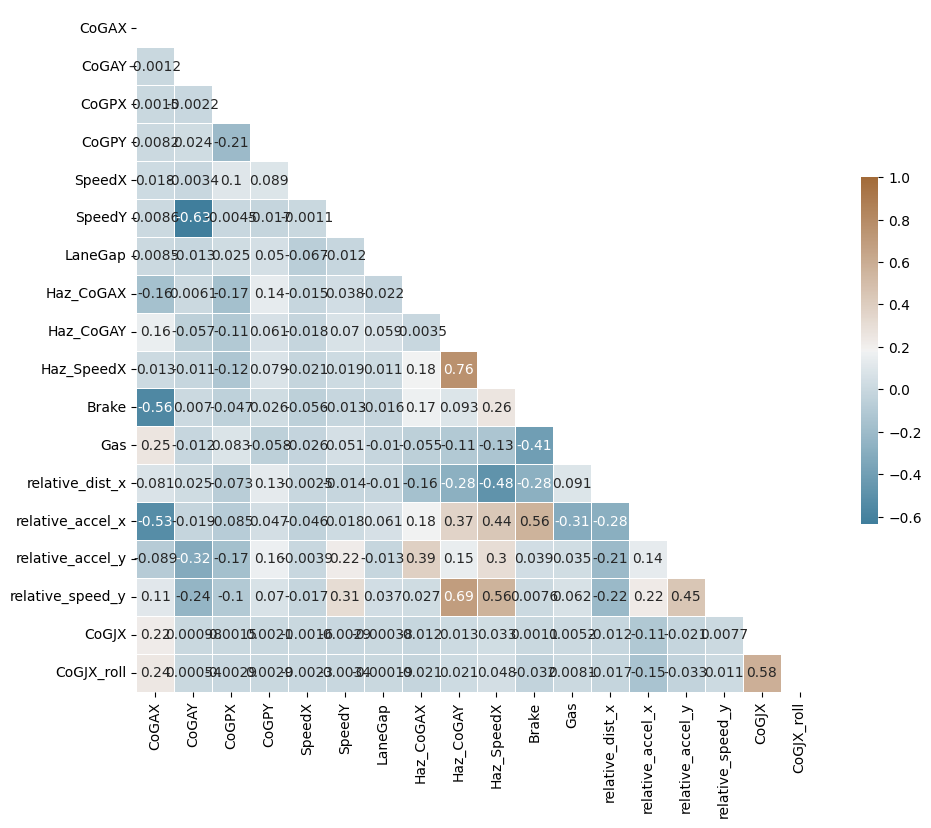

In [27]:
# TMAJ
# print(df_sktime_tmaj.columns)
df_tmaj1 = df_sktime_tmaj.drop(['Haz_CoGPX', 'Haz_CoGPY', 'Haz_CoGAY', 'relative_dist_x', 'relative_accel_y', 'CoGAX_roll','relative_accel_x_roll'], axis =1)
# corrOne(df_tmaj1)

# TMIN
# print(df_sktime_tmin.columns)
df_tmin1 = df_sktime_tmin.drop(['Haz_CoGPX', 'Haz_CoGPY', 'Haz_CoGAY', 'relative_speed_x', 'CoGAX_roll', 'relative_accel_x_roll'], axis =1)
# corrOne(df_tmin1)

# SIG
# print(df_sktime_sig.columns)
df_sig1 = df_sktime_sig.drop(['Haz_CoGPX', 'Haz_CoGPY', 'Haz_SpeedY', 'SteeringWheelAngle', 'relative_accel_y', 'relative_speed_x', 'CoGAX_roll',
                             'relative_accel_x_roll'], axis =1)
# corrOne(df_sig1)

# HSIG
df_hsig1 = df_sktime_hsig.drop(['Haz_CoGPX', 'Haz_CoGPY', 'SteeringWheelAngle', 'relative_dist_y', 'Haz_SpeedY', 'relative_speed_x',
                               'CoGAX_roll', 'relative_accel_x_roll'], axis =1)

# print(df_hsig1)
corrOne(df_hsig1)


# df_light1 = df_sktime_light.drop(['Haz_CoGPX', 'Haz_CoGPY', 'Haz_CoGAY', 'Haz_SpeedY', 'relative_accel_x_roll', 'relative_speed_x', 'CoGAX_roll', 'SteeringWheelAngle'], axis=1)
# corr_light1 = df_light1.corr()
# # visualize_corr(corr_light1)

# ###signs###
# # print(df_sktime_sign.columns)
# corr_sign = df_sktime_sign.corr()
# # visualize_corr(corr_sign)
# df_sign1 = df_sktime_sign.drop(['Haz_CoGPX', 'Haz_CoGAY', 'CoGAX_roll', 'relative_speed_x', 'relative_accel_x_roll'], axis=1)

# corr_sign1 = df_sign1.corr()
# visualize_corr(corr_sign1)


# print(len(df_light1.columns))

# print(df_light1.columns)
# print(len(df_sign1.columns))

Adjusted Mutual Info Score
take the largest value and then recalculate
keep going until no future value is larger than last calculated value

In [53]:
# calculate the adjusted_mutual_info_score between pairs of features and each feature and the correct label then return to be used in MSTS score

from itertools import combinations

def amis(X_train, X_test, y_train, y_test, i, mod):
    
    yff_list = []
    yff_list1 = []
    ycf_list = []
    idx = pd.IndexSlice
       
    for k in i:
        x_train = pd.DataFrame(X_train.loc[idx[:, :], X_train.columns[k]])
        x_test = pd.DataFrame(X_test.loc[idx[:, :], X_train.columns[k]])
        
        mod.fit(x_train, y_train)
        y_pred = mod.predict(x_test)

        yff_list.append(y_pred)

        ycf_indi = adjusted_mutual_info_score(y_pred, y_test)
        ycf_list.append(ycf_indi)

    # print(ycf_list)

    # print(yff_list)
    
    for j in combinations(range(len(i)), 2):
        # print(j)
        # print(yff_list)
        
        yff_list1.append(adjusted_mutual_info_score(yff_list[j[0]], yff_list[j[1]]))

        # print(yff_list1)

        
    yff = np.mean(yff_list1)
    ycf = np.mean(ycf_list)
    
    return yff, ycf

In [54]:
def msts_score_round3plus(df, y, lst_test, lst_keep):
    
    idx = pd.IndexSlice
    fold_list=[]
    keep_score = []
    # create a model to run
    mod = RocketClassifier(num_kernels=2000)
    
    for i in lst_test:
    
        yff_kfold=[]
        ycf_kfold = []
        
        for j in range(5):
            X_train, X_test, y_train, y_test, fold_list = randomize(df, y, j, fold_list)
            yff, ycf = amis(X_train, X_test, y_train, y_test, lst_keep+[i], mod)
    
            yff_kfold.append(yff)
            ycf_kfold.append(ycf)
    
        yff_final=np.mean(yff_kfold)
        ycf_final=np.mean(ycf_kfold)
    
        g = len(lst_keep)+1
        msts_score = (g*ycf_final)/(np.sqrt(g+g*(g-1)*yff_final))
    
        print(i, np.round(msts_score,3))
        keep_score.append([lst_keep, i,np.round(msts_score,3)])
    
    print(keep_score)
    return(keep_score)

In [ ]:
print(df_hsig1)
print(y_hsig)

In [63]:
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics.cluster import adjusted_mutual_info_score
from itertools import combinations

# Switch between running function for light controlled intersection and sign controlled
# data = df_light1
# y= y_light

for i in [3]:    
    print(i)
    if i == 0:
        data = df_tmaj1
        y = y_tmaj
    elif i == 1:
        data = df_tmin1
        y = y_tmin
    elif i == 2:
        data = df_sig1
        y = y_sig
    elif i == 3:
        x = df_hsig1
        y = y_hsig
    
    idx = pd.IndexSlice
    fold_list=[]
    keep_score = []

    n = len(data.columns)
    lst = np.linspace(0,n-1,num=n)

    # calculated the adjusted mutual interest score for each pair of features

    for i in combinations(lst, 2):
        i =[ int(x) for x in i ]
        yff_kfold=[]
        ycf_kfold = []

        for j in range(5):
            X_train, X_test, y_train, y_test, fold_list = randomize(data, y, j, fold_list)
            mod = RocketClassifier(num_kernels=2000)

            yff, ycf = amis(X_train, X_test, y_train, y_test, i, mod)

            yff_kfold.append(yff)
            ycf_kfold.append(ycf)

        yff_final=np.mean(yff_kfold)
        ycf_final=np.mean(ycf_kfold)

        msts_score = (2*ycf_final)/(np.sqrt(2+2*(2-1)*yff_final))

        keep_score.append(i + [np.round(msts_score,3)])
        print(keep_score)
    print(keep_score)
    if i == 0:
        keep_score_tmaj = keep_score
    elif i == 1:
        keep_score_tmin = keep_score
    elif i ==  2:
        keep_score_sig = keep_score
    elif i == 3:
        keep_score_hsig = keep_score
    
    
        # print(X_train.columns[i], X_train.columns[i+1], msts_score)

3
[[0, 1, 0.037]]
[[0, 1, 0.037], [0, 2, 0.013]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012], [0, 4, 0.02]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012], [0, 4, 0.02], [0, 5, 0.005]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012], [0, 4, 0.02], [0, 5, 0.005], [0, 6, -0.036]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012], [0, 4, 0.02], [0, 5, 0.005], [0, 6, -0.036], [0, 7, -0.036]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012], [0, 4, 0.02], [0, 5, 0.005], [0, 6, -0.036], [0, 7, -0.036], [0, 8, -0.035]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012], [0, 4, 0.02], [0, 5, 0.005], [0, 6, -0.036], [0, 7, -0.036], [0, 8, -0.035], [0, 9, -0.028]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012], [0, 4, 0.02], [0, 5, 0.005], [0, 6, -0.036], [0, 7, -0.036], [0, 8, -0.035], [0, 9, -0.028], [0, 10, -0.014]]
[[0, 1, 0.037], [0, 2, 0.013], [0, 3, 0.012], [0, 4, 0.02], [0, 5, 0.005], [0, 6, -0.036], [0, 7, -0.036], [0, 8, -0.035], [0, 9, -0.028], [0, 10, -0.014]

In [30]:
keep_score_tmin = [[0, 1, 0.002], [0, 2, 0.112], [0, 3, -0.017], [0, 4, 0.104], [0, 5, 0.033], [0, 6, 0.034], [0, 7, 0.04], [0, 8, 0.068], [0, 9, 0.028], [0, 10, 0.041], [0, 11, 0.097], [0, 12, 0.06], [0, 13, 0.073], [0, 14, 0.046], [0, 15, 0.086], [0, 16, 0.04], [0, 17, 0.098], [0, 18, -0.003], [0, 19, 0.074], [1, 2, -0.033], [1, 3, -0.013], [1, 4, 0.024], [1, 5, -0.019], [1, 6, -0.049], [1, 7, 0.03], [1, 8, 0.06], [1, 9, 0.026], [1, 10, -0.01], [1, 11, 0.082], [1, 12, -0.012], [1, 13, 0.198], [1, 14, 0.024], [1, 15, 0.088], [1, 16, 0.075], [1, 17, -0.02], [1, 18, -0.024], [1, 19, 0.034], [2, 3, 0.076], [2, 4, 0.046], [2, 5, 0.007], [2, 6, 0.015], [2, 7, 0.039], [2, 8, 0.041], [2, 9, -0.003], [2, 10, 0.032], [2, 11, 0.092], [2, 12, 0.023], [2, 13, 0.09], [2, 14, 0.008], [2, 15, 0.048], [2, 16, 0.118], [2, 17, 0.052], [2, 18, -0.019], [2, 19, 0.058], [3, 4, 0.082], [3, 5, 0.001], [3, 6, -0.03], [3, 7, 0.047], [3, 8, 0.043], [3, 9, 0.034], [3, 10, 0.032], [3, 11, 0.079], [3, 12, 0.007], [3, 13, 0.065], [3, 14, 0.017], [3, 15, 0.072], [3, 16, 0.024], [3, 17, -0.02], [3, 18, 0.005], [3, 19, 0.051], [4, 5, 0.097], [4, 6, -0.026], [4, 7, 0.169], [4, 8, 0.067], [4, 9, 0.031], [4, 10, 0.074], [4, 11, 0.106], [4, 12, 0.038], [4, 13, 0.031], [4, 14, 0.073], [4, 15, 0.106], [4, 16, 0.024], [4, 17, -0.016], [4, 18, 0.108], [4, 19, 0.044], [5, 6, -0.023], [5, 7, 0.041], [5, 8, 0.021], [5, 9, -0.013], [5, 10, 0.101], [5, 11, 0.166], [5, 12, -0.014], [5, 13, 0.011], [5, 14, 0.084], [5, 15, 0.022], [5, 16, 0.041], [5, 17, 0.006], [5, 18, -0.003], [5, 19, 0.044], [6, 7, -0.018], [6, 8, 0.045], [6, 9, 0.023], [6, 10, 0.008], [6, 11, 0.099], [6, 12, -0.05], [6, 13, 0.085], [6, 14, 0.04], [6, 15, 0.078], [6, 16, 0.117], [6, 17, 0.019], [6, 18, 0.006], [6, 19, -0.018], [7, 8, 0.076], [7, 9, 0.042], [7, 10, 0.064], [7, 11, 0.095], [7, 12, 0.048], [7, 13, 0.096], [7, 14, 0.064], [7, 15, 0.121], [7, 16, 0.002], [7, 17, 0.003], [7, 18, 0.033], [7, 19, 0.069], [8, 9, 0.033], [8, 10, 0.038], [8, 11, 0.116], [8, 12, 0.069], [8, 13, 0.121], [8, 14, 0.091], [8, 15, 0.091], [8, 16, 0.078], [8, 17, 0.084], [8, 18, 0.085], [8, 19, 0.035], [9, 10, 0.009], [9, 11, 0.062], [9, 12, 0.005], [9, 13, 0.124], [9, 14, 0.034], [9, 15, 0.072], [9, 16, 0.01], [9, 17, 0.035], [9, 18, 0.009], [9, 19, 0.024], [10, 11, 0.118], [10, 12, 0.03], [10, 13, 0.188], [10, 14, 0.047], [10, 15, 0.134], [10, 16, 0.055], [10, 17, 0.077], [10, 18, 0.026], [10, 19, 0.035], [11, 12, 0.098], [11, 13, 0.128], [11, 14, 0.116], [11, 15, 0.111], [11, 16, 0.089], [11, 17, 0.019], [11, 18, 0.084], [11, 19, 0.154], [12, 13, 0.097], [12, 14, 0.058], [12, 15, 0.063], [12, 16, 0.014], [12, 17, -0.031], [12, 18, 0.064], [12, 19, -0.016], [13, 14, 0.157], [13, 15, 0.088], [13, 16, 0.202], [13, 17, 0.073], [13, 18, 0.056], [13, 19, 0.084], [14, 15, 0.112], [14, 16, 0.041], [14, 17, 0.084], [14, 18, 0.059], [14, 19, 0.081], [15, 16, 0.132], [15, 17, 0.024], [15, 18, 0.058], [15, 19, 0.038], [16, 17, 0.03], [16, 18, 0.017], [16, 19, 0.016], [17, 18, -0.019], [17, 19, 0.001], [18, 19, 0.105]]

In [61]:
keep_score_sig = [[0, 1, 0.825], [0, 2, 0.856], [0, 3, 0.758], [0, 4, 0.758], [0, 5, 0.778], [0, 6, 0.733], [0, 7, 0.607], [0, 8, 0.627], [0, 9, 0.627], [0, 10, 0.79], [0, 11, 0.854], [0, 12, 0.849], [0, 13, 0.531], [0, 14, 0.887], [0, 15, 0.691], [0, 16, 0.877], [0, 17, 0.82], [1, 2, 0.817], [1, 3, 0.744], [1, 4, 0.843], [1, 5, 0.744], [1, 6, 0.728], [1, 7, 0.601], [1, 8, 0.615], [1, 9, 0.599], [1, 10, 0.76], [1, 11, 0.839], [1, 12, 0.826], [1, 13, 0.455], [1, 14, 0.856], [1, 15, 0.726], [1, 16, 0.811], [1, 17, 0.746], [2, 3, 0.819], [2, 4, 0.822], [2, 5, 0.775], [2, 6, 0.728], [2, 7, 0.693], [2, 8, 0.694], [2, 9, 0.664], [2, 10, 0.902], [2, 11, 0.847], [2, 12, 0.873], [2, 13, 0.638], [2, 14, 0.865], [2, 15, 0.76], [2, 16, 0.87], [2, 17, 0.808], [3, 4, 0.743], [3, 5, 0.694], [3, 6, 0.604], [3, 7, 0.373], [3, 8, 0.484], [3, 9, 0.428], [3, 10, 0.809], [3, 11, 0.772], [3, 12, 0.797], [3, 13, 0.368], [3, 14, 0.779], [3, 15, 0.569], [3, 16, 0.722], [3, 17, 0.643], [4, 5, 0.752], [4, 6, 0.719], [4, 7, 0.58], [4, 8, 0.648], [4, 9, 0.618], [4, 10, 0.762], [4, 11, 0.857], [4, 12, 0.895], [4, 13, 0.592], [4, 14, 0.832], [4, 15, 0.74], [4, 16, 0.817], [4, 17, 0.749], [5, 6, 0.712], [5, 7, 0.434], [5, 8, 0.429], [5, 9, 0.456], [5, 10, 0.76], [5, 11, 0.742], [5, 12, 0.84], [5, 13, 0.488], [5, 14, 0.803], [5, 15, 0.674], [5, 16, 0.784], [5, 17, 0.733], [6, 7, 0.481], [6, 8, 0.512], [6, 9, 0.503], [6, 10, 0.703], [6, 11, 0.764], [6, 12, 0.768], [6, 13, 0.406], [6, 14, 0.748], [6, 15, 0.55], [6, 16, 0.725], [6, 17, 0.691], [7, 8, 0.175], [7, 9, 0.188], [7, 10, 0.664], [7, 11, 0.634], [7, 12, 0.674], [7, 13, 0.11], [7, 14, 0.648], [7, 15, 0.347], [7, 16, 0.664], [7, 17, 0.604], [8, 9, 0.182], [8, 10, 0.654], [8, 11, 0.644], [8, 12, 0.684], [8, 13, 0.108], [8, 14, 0.693], [8, 15, 0.381], [8, 16, 0.564], [8, 17, 0.502], [9, 10, 0.655], [9, 11, 0.662], [9, 12, 0.681], [9, 13, 0.203], [9, 14, 0.617], [9, 15, 0.356], [9, 16, 0.617], [9, 17, 0.586], [10, 11, 0.86], [10, 12, 0.92], [10, 13, 0.588], [10, 14, 0.845], [10, 15, 0.726], [10, 16, 0.884], [10, 17, 0.829], [11, 12, 0.872], [11, 13, 0.592], [11, 14, 0.848], [11, 15, 0.769], [11, 16, 0.803], [11, 17, 0.835], [12, 13, 0.664], [12, 14, 0.91], [12, 15, 0.765], [12, 16, 0.865], [12, 17, 0.84], [13, 14, 0.549], [13, 15, 0.38], [13, 16, 0.59], [13, 17, 0.591], [14, 15, 0.734], [14, 16, 0.84], [14, 17, 0.77], [15, 16, 0.682], [15, 17, 0.683], [16, 17, 0.801]]

In [59]:
# keep_score_lights1 = keep_score

# keep_score_tmaj1
# print(keep_score_tmin)
# print(keep_score_tmaj1)
# %store keep_score_tmin
%store keep_score_tmaj1
%store keep_score_sig
# print(keep_score_lights1)

Stored 'keep_score_tmaj1' (list)


In [ ]:
# keep_score_signs1 = keep_score
print(keep_score_signs1)

In [ ]:
print(df_light1.columns)

In [ ]:
####round 2#####
# "lights", 
for lightsorsigns in ["signs"]:
    if lightsorsigns == "lights":
        print("lights")
        keep_score1 = keep_score_lights1
        df = df_light1
        y= y_light

    elif lightsorsigns == "signs":
        print("signs")
        keep_score1 = keep_score_signs1
        df = df_sign1
        y = y_sign 

    print(keep_score1)
    # convert from list of list into np array
    keep_score3 = np.stack(keep_score1)
    
    # find the max msts score of all the combos
    p = np.argmax(keep_score3[:,2])
    print(keep_score3[p])
    
    # identify the column index values for the chosen pair
    ind1 = int(keep_score3[p,0])
    ind2 = int(keep_score3[p,1])
    
    # create a vector that contains only the remaining columns
    n = len(df.columns) 
    
    lst = list(np.linspace(0,n-1,num=n))
    lst1 =[ int(x) for x in lst ]
    
    lst1.remove(ind1)
    lst1.remove(ind2)
    
    lst_all = [ind1, ind2]
    
    keep_score_round2 = msts_score_round3plus(df, y, lst1, lst_all)

    if lightsorsigns =="lights":
        keep_score_lights2 = keep_score_round2
    if lightsorsigns == "signs":
        keep_score_signs2 = keep_score_round2

Print results after round 2

In [ ]:
def checkscore(round1, round2):
    
    x1 = pd.DataFrame(round1, columns = ['var1', 'var2', 'score'])
    
    index = x1['score'].idxmax()
    value1 =x1['score'].max()
    print("\n Last Round")
    print(x1.loc[index])

    x2 = pd.DataFrame(round2, columns = ['var1', 'var2', 'score'])
    index2 = x2['score'].idxmax()
    value2 = x2['score'].max()
    
    if value2 > value1:
        print("\nKeeping Going to Next Round\n")
        print(x2.loc[index2])

# find the max msts score of all the combos
# checkscore(keep_score_lights1, keep_score_lights2)
checkscore(keep_score_signs1, keep_score_signs2)

In [ ]:
####round 3##### 
# lights
# keep_score_round2=keep_score_lights2
# df=df_light1
# y=y_light

# ind1 = 3
# ind2 = 11
# ind3 = 14

# switch between lights and signs
# signs
keep_score_round2 = keep_score_signs2
df = df_sign1
y= y_sign

ind1 = 14
ind2 = 16
ind3 = 4

# convert from list of list into np array
keep_score3 = np.stack(keep_score_round2)

# find the max msts score of all the combos
# # create a vector that contains only the remaining columns

n = len(df.columns) 
lst = list(np.linspace(0,n-1,num=n))
lst1 =[ int(x) for x in lst ]

lst1.remove(ind1)
lst1.remove(ind2)
lst1.remove(ind3)

lst_all = [ind1, ind2, ind3]

keep_score_round3 = msts_score_round3plus(df, y, lst1, lst_all)
print(keep_score_round3)

In [ ]:
keep_score_sign2 = [[[14, 16, 4], 0, 0.255], [[14, 16, 4], 1, 0.194], [[14, 16, 4], 2, 0.255], [[14, 16, 4], 3, 0.217], [[14, 16, 4], 5, 0.211], [[14, 16, 4], 6, 0.214], [[14, 16, 4], 7, 0.229], [[14, 16, 4], 8, 0.227], [[14, 16, 4], 9, 0.233], [[14, 16, 4], 10, 0.246], [[14, 16, 4], 11, 0.278], [[14, 16, 4], 12, 0.274], [[14, 16, 4], 13, 0.25], [[14, 16, 4], 15, 0.23], [[14, 16, 4], 17, 0.211], [[14, 16, 4], 18, 0.209], [[14, 16, 4], 19, 0.2], [[14, 16, 4], 20, 0.23]]
[[[14, 16, 4], 0, 0.255], [[14, 16, 4], 1, 0.194], [[14, 16, 4], 2, 0.255], [[14, 16, 4], 3, 0.217], [[14, 16, 4], 5, 0.211], [[14, 16, 4], 6, 0.214], [[14, 16, 4], 7, 0.229], [[14, 16, 4], 8, 0.227], [[14, 16, 4], 9, 0.233], [[14, 16, 4], 10, 0.246], [[14, 16, 4], 11, 0.278], [[14, 16, 4], 12, 0.274], [[14, 16, 4], 13, 0.25], [[14, 16, 4], 15, 0.23], [[14, 16, 4], 17, 0.211], [[14, 16, 4], 18, 0.209], [[14, 16, 4], 19, 0.2], [[14, 16, 4], 20, 0.23]]

In [ ]:
# results after round 3 - light
# keep_score_round3_light = keep_score_round3
print(keep_score_round3_light)
checkscore(keep_score_lights2, keep_score_round3_light)

In [ ]:
# results after round 3 - sign
# keep_score_round3_sign = keep_score_round3
print(keep_score_round3_sign)
checkscore(keep_score_sign2, keep_score_round3_sign)

In [ ]:
### round4### only run for signs

# signs
keep_score_round4 = keep_score_round3_sign
df = df_sign1
y= y_sign

ind1 = 3
ind2 = 9
ind3 = 10
ind4 = 7

# convert from list of list into np array
keep_score4 = np.stack(keep_score_round4)

# find the max msts score of all the combos
# # create a vector that contains only the remaining columns
n = len(df.columns) 
lst = list(np.linspace(0,n-1,num=n))
lst1 =[ int(x) for x in lst ]

lst1.remove(ind1)
lst1.remove(ind2)
lst1.remove(ind3)
lst1.remove(ind4)

lst_all = [ind1, ind2, ind3, ind4]
print(lst_all)

keep_score_round4_lights= msts_score_round3plus(df, y, lst1, lst_all)

print(keep_score_round4)


In [ ]:
# keep_score_round4_sign = keep_score_round4
print(keep_score_round4_sign)
checkscore(keep_score_round3_sign, keep_score_round4_signs)

In [20]:
# keep 14, 16, 4 results from including v2v variables
print(df_sign1.columns)

df_sign2 = df_sign1.drop(['CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedY', 'LaneGap',
       'Haz_CoGAX', 'Haz_CoGPY', 'Haz_SpeedX', 'Haz_SpeedY', 'Brake', 'Gas',
       'SteeringWheelAngle', 'relative_dist_y',
       'relative_accel_y', 'relative_speed_y', 'CoGJX',
       'CoGJX_roll'], axis=1)

df_sign2

NameError: name 'df_sign1' is not defined

In [20]:
# Redo
print(df_light1.columns)
# 3,11,14 results including v2v variables

df_light1
df_light2_new = df_light1.drop(['CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedY', 'LaneGap',
       'Haz_CoGAX', 'Haz_SpeedX', 'Brake', 'Gas', 'relative_dist_x',
       'relative_dist_y', 'relative_accel_x', 'relative_accel_y',
       'relative_speed_y', 'CoGJX', 'CoGJX_roll'], axis=1)

df_light2_new



Index(['CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'LaneGap',
       'Haz_CoGAX', 'Haz_SpeedX', 'Brake', 'Gas', 'relative_dist_x',
       'relative_dist_y', 'relative_accel_x', 'relative_accel_y',
       'relative_speed_y', 'CoGJX', 'CoGJX_roll'],
      dtype='object')


SpeedX
level_0 level_1           
0       0        63.979500
        1        63.971900
        2        63.964400
        3        63.956800
        4        63.949300
...                    ...
238     745      -0.015170
        746      -0.011928
        747      -0.008936
        748      -0.006268
        749      -0.003781

[179250 rows x 1 columns]

Original Data - In paper

In [21]:
# Original -in paper 
# V2V: Brake, p_(longP-H)

print(df_light1.columns)

df_light2_v2v_1 = df_light1.drop(['CoGAX', 'CoGAY','CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'LaneGap', 'Haz_CoGAX',
       'Haz_SpeedX', 'Gas', 
       'relative_dist_y', 'relative_accel_x', 'relative_accel_y',
       'relative_speed_y', 'CoGJX', 'CoGJX_roll'], axis=1)

# No V2V: CoGAY, relative_accel_x, SpeedX, SpeedY, relative_dist_x

df_light2_1 = df_light1.drop(['CoGAX', 'CoGPX', 'CoGPY', 'LaneGap', 'Haz_CoGAX',
       'Haz_SpeedX', 'Brake', 'Gas', 'relative_dist_y', 'relative_accel_y',
       'relative_speed_y', 'CoGJX', 'CoGJX_roll'], axis=1)

df_light2_v2v_1
df_light2_1



Index(['CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'LaneGap',
       'Haz_CoGAX', 'Haz_SpeedX', 'Brake', 'Gas', 'relative_dist_x',
       'relative_dist_y', 'relative_accel_x', 'relative_accel_y',
       'relative_speed_y', 'CoGJX', 'CoGJX_roll'],
      dtype='object')


CoGAY     SpeedX    SpeedY  relative_dist_x  \
level_0 level_1                                                   
0       0       -0.026287  63.979500  0.001356           177.20   
        1       -0.023354  63.971900  0.001342           176.92   
        2       -0.023024  63.964400  0.001316           176.63   
        3       -0.027349  63.956800  0.001279           176.35   
        4       -0.025460  63.949300  0.001251           176.06   
...                   ...        ...       ...              ...   
238     745     -0.000967  -0.015170  0.000910             3.53   
        746     -0.010861  -0.011928  0.000875             3.72   
        747      0.008660  -0.008936  0.000817             3.91   
        748     -0.001221  -0.006268  0.000809             4.11   
        749     -0.006240  -0.003781  0.000774             4.32   

                 relative_accel_x  
level_0 level_1                    
0       0                0.119065  
        1                0.141238  
        2                0.136611  
        3                0.160566  
        4                0.124081  
...                           ...  
238     745              1.396434  
        746              1.400634  
        747              1.405230  
        748              1.409443  
        749              1.414899  

[179250 rows x 5 columns]

In [22]:
# Original -in paper 
# V2V: Brake, Gas, v_longP
print(df_sign1.columns)

df_sign2_v2v_1 = df_sign1.drop(['CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedY', 'LaneGap',
       'Haz_CoGAX', 'Haz_CoGPY', 'Haz_SpeedX', 'Haz_SpeedY', 
       'SteeringWheelAngle', 'relative_dist_x', 'relative_dist_y',
       'relative_accel_x', 'relative_accel_y', 'relative_speed_y', 'CoGJX',
       'CoGJX_roll'], axis=1)

# Non v2v: relative_accel_x, CoGAX, SpeedX
df_sign2_1 = df_sign1.drop(['CoGAY', 'CoGPX', 'CoGPY', 'SpeedY', 'LaneGap',
       'Haz_CoGAX', 'Haz_CoGPY', 'Haz_SpeedX', 'Haz_SpeedY', 'Brake', 'Gas',
       'SteeringWheelAngle', 'relative_dist_x', 'relative_dist_y',
       'relative_accel_y', 'relative_speed_y', 'CoGJX',
       'CoGJX_roll'], axis=1)

df_sign2_1
df_sign2_v2v_1

NameError: name 'df_sign1' is not defined

In [ ]:
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sktime.classification.hybrid import HIVECOTEV2
# from sklearn.model_selection import cross_val_score

def classification(classifier_type, df_x, y):
    print(df_x.columns())
    y_pred_list = []
    f1_list = []
    fold_list=[]
    roc_list=[]
    for j in range(5):
        X_train, X_test, y_train, y_test, fold_list = randomize(df_x, y, j, fold_list)

        if classifier_type == "rocket":
            mod = RocketClassifier(num_kernels=4000)
        elif classifier_type == "hc2":
            mod = HIVECOTEV2(time_limit_in_minutes=1)
 
        mod.fit(X_train, y_train)
        #timeit (look into adding the time))
        y_pred = mod.predict(X_test)

        score = accuracy_score(y_test, y_pred)
        y_pred_list.append(score)
        f1_list.append(f1_score(y_test, y_pred))
        roc_list.append(roc_auc_score(y_test, y_pred))

        print(confusion_matrix(y_test, y_pred))
        
    y_pred_avg = np.mean(y_pred_list)
    f1_avg = np.mean(f1_list)
    roc_avg = np.mean(roc_list)

    print(classifier_type, "avg", np.round(y_pred_avg,2), "f1", f1_avg, "roc", roc_avg)


In [ ]:
for i in ["rocket", "hc2"]:
    classification(i, df_light2_1, y_light)

In [ ]:
for i in ["rocket", "hc2"]:
    classification(i, df_sign2_1, y_sign)

In [ ]:
for i in ["rocket", "hc2"]:
    classification(i, df_sign2_v2v_1, y_sign)

In [ ]:
for i in ["rocket", "hc2"]:
    classification(i, df_light2_v2v_1, y_light)

Brake


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   46.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[16  1]
 [ 2 29]]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.3s finished


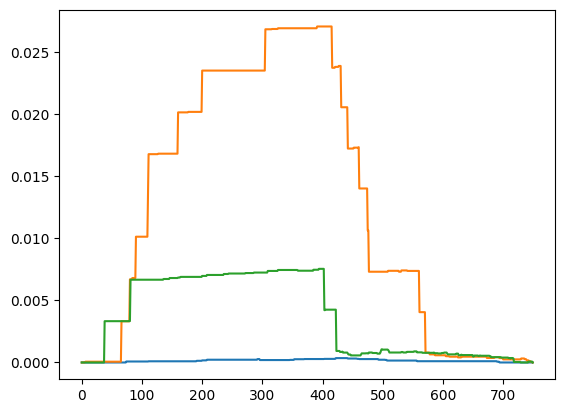

(1, 750, 3)
relative_dist_x


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   49.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[17  0]
 [ 0 31]]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished


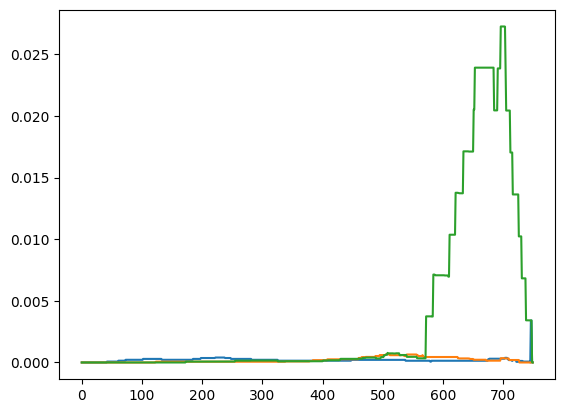

(2, 750, 3)
lights_v2v avg 0.97 f1 0.98 roc 0.97


In [61]:
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# datasets=["lights", "lights_v2v", "signs", "signs_v2v"]

datasets = ["lights_v2v"]

for x in datasets:
    if x == "signs":
        X = df_sign2_1
        y = y_sign
    elif x == "signs_v2v":
        X = df_sign2_v2v_1
        y = y_sign
    elif x == "lights":
        X = df_light2_1
        y = y_light
    elif x == "lights_v2v":
        X = df_light2_v2v_1
        y = y_light
    elif x == "light2_new":
        X = df_light2_new
        y= y_light

    idx = pd.IndexSlice
    y_pred_list = []
    fold_list=[]
    feature_importances = []
    accuracy_list = []
    f1_list=[]
    roc_list = []
        
    X_train, X_test, y_train, y_test, fold_list = randomize(X, y, 0, fold_list)
    
    for i in X_train.columns:
        print(i)
        
        df_train_1 = pd.DataFrame(X_train.loc[idx[:, :], i])
        df_test_1 = pd.DataFrame(X_test.loc[idx[:, :], i])
    
        classifier = ComposableTimeSeriesForestClassifier(n_estimators=10, verbose=1)
        classifier.fit(df_train_1, y_train)

        #timeit
        y_pred = classifier.predict(df_test_1)
        
        y_pred_list.append(y_pred)
        
        print(confusion_matrix(y_test, y_pred))
        
        score = accuracy_score(y_test, y_pred)
        accuracy_list.append(score)
        
        f1_list.append(f1_score(y_test, y_pred))
        roc_list.append(roc_auc_score(y_test, y_pred))
            
        plt.plot(classifier.feature_importances_)
        plt.show()
        
        feature_importances.append(classifier.feature_importances_)
        
        print(np.shape(feature_importances))
    
    acc_avg = np.mean(accuracy_list)
    f1_avg = np.mean(f1_list)
    roc_avg = np.mean(roc_list)
    
    print(x, "avg", np.round(acc_avg,2), "f1", np.round(f1_avg,2), "roc", np.round(roc_avg,2))

    if x == "lights":
        feature_importances_lights = feature_importances
    elif x == "signs":
        feature_importances_signs = feature_importances
    elif x == "signs_v2v":
        feature_importances_signs_v2v = feature_importances
    elif x == "lights_v2v":
        feature_importances_lights_v2v = feature_importances


In [24]:
# feature_importances_lights_good = feature_importances_lights
feature_importances_lights_v2v_good = feature_importances_lights_v2v

# feature_importances_signs_good = feature_importances_signs
# feature_importances_signs_v2v_good = feature_importances_signs_v2v

# feature_importances_signs_v2v

In [25]:
%store df_sign2_1
%store df_sign2_v2v_1
%store df_light2_1
%store df_light2_v2v_1

Stored 'df_sign2_1' (DataFrame)
Stored 'df_sign2_v2v_1' (DataFrame)
Stored 'df_light2_1' (DataFrame)
Stored 'df_light2_v2v_1' (DataFrame)


In [26]:
# %store feature_importances_lights_good
# %store feature_importances_lights_v2v_good
# %store feature_importances_signs_good
# %store feature_importances_signs_v2v_good

Stored 'feature_importances_lights_v2v_good' (list)


In [59]:
from sklearn import tree
from sktime.datasets import load_gunpoint

X = df_light2_v2v_1
y = y_light

# X_train, X_test, y_train, y_test, fold_list = randomize(X, y, 0, fold_list)
# sample = pd.DataFrame(X_test.loc[idx[:, :], i])


tree.export_graphviz(test_classifier)

AttributeError: 'ComposableTimeSeriesForestClassifier' object has no attribute 'tree_'

In [51]:

from sktime.datasets import load_gunpoint

# Load example dataset (replace with your own dataset)
X_train, y_train = load_gunpoint(split="train", return_X_y=True)
X_train.iloc[[0]]


# # Initialize the ComposableTimeSeriesForest classifier
# ctsf = ComposableTimeSeriesForest(n_estimators=10)

# # Fit the classifier to the training data
# ctsf.fit(X_train, y_train)

# # Extract the decision path for a specific sample
# sample_index = 0  # Index of the sample you want to get the decision path for
# sample = X_train.iloc[[sample_index]]  # Assuming X_train is a DataFrame
# decision_path = ctsf.get_decision_paths(sample)

# print("Decision path for sample {}: ".format(sample_index))
# print(decision_path)


,dim_0
0,0 -0.647885 1 -0.641992 2 -0.63818...


In [38]:
# test_classifier = classifier
# test_claddifier1 = classifier.clone()

In [38]:
# print(df_light2_1.columns)
# print(df_light2_v2v_1.columns)
# print(df_sign2_1.columns)
# print(df_sign2_v2v_1.columns)

# df_light2_1.to_excel("lights.xlsx")
# df_light2_v2v_1.to_excel("lights_v2v.xlsx")
# df_sign2_1.to_excel("signs.xlsx")
# df_sign2_v2v_1.to_excel("signs_v2v.xlsx")

with open('ysign.csv', 'w', newline='') as file:
    # Step 4: Using csv.writer to write the list to the CSV file
    writer = csv.writer(file)
    writer.writerow(y_sign) # Use writerow for single list

with open('ylight.csv', 'w', newline='') as file:
    # Step 4: Using csv.writer to write the list to the CSV file
    writer = csv.writer(file)
    writer.writerow(y_light) # Use writerow for single list

In [ ]:
with open('ysign.csv', 'w', newline='') as file:
    # Step 4: Using csv.writer to write the list to the CSV file
    writer = csv.writer(file)
    writer.writerow(y_sign) # Use writerow for single list


In [ ]:
# keep brake and plong results from including v2v variables
# print(df_light1.columns)

df_light3 = df_light1.drop(['CoGAX', 'CoGPX', 'CoGPY', 'SpeedX', 'SpeedY', 'LaneGap', 'Haz_CoGAX',
       'Haz_SpeedX', 'Gas', 'SteeringWheelAngle', 
       'relative_dist_y', 'relative_accel_x', 'relative_accel_y',
       'relative_speed_y', 'CoGJX', 'CoGJX_roll'], axis=1)

# print(df_sign1.columns)

df_sign3 = df_sign1.drop(['CoGAX', 'CoGAY', 'CoGPX', 'CoGPY', 'SpeedY', 'LaneGap',
       'Haz_CoGAX', 'Haz_CoGPY', 'Haz_SpeedX', 'Haz_SpeedY', 'SteeringWheelAngle', 'relative_dist_x', 'relative_dist_y',
       'relative_accel_x', 'relative_accel_y', 'relative_speed_y', 'CoGJX',
       'CoGJX_roll'], axis=1)

# df_light3
# df_sign3

In [50]:
# df_light3.to_excel("lights.xlsx")
df_light2_new.to_excel("lights_new.xlsx")